In [1]:
import numpy as np
import pandas as pd

In [2]:
#data = pd.read_csv('temp/因子建模数据.csv',encoding = 'GBK',engine = 'python')

data = pd.read_csv('temp/因子数据提取.csv',encoding = 'GBK',engine = 'python')
data.dropna(inplace = True)

In [3]:
print('因子列表：')
for x in data.columns[2:-2]:
    print(x)

因子列表：
总股本
每股资本公积
每股未分配利润
基本每股收益
基本每股收益同比增长(%)
每股净资产
每股净资产相对年初增长(%)
每股现金流
每股营业收入
营业收入同比增速(%)
加权平均净资产收益率
摊薄净资产收益率同比增长(%)
净利润同比增长
上市年限
交通运输、仓储和邮政业
住宿和餐饮业
信息传输、软件和信息技术服务业
农、林、牧、渔业
制造业
卫生和社会工作
建筑业
房地产业
批发和零售业
教育
文化、体育和娱乐业
水利、环境和公共设施管理业
电力、热力、燃气及水生产和供应业
科学研究和技术服务业
租赁和商务服务业
综合
采矿业
金融业
是否次新股
股价（年末最后20个交易日收盘价加权平均）
股价年化波动率
本年送转比例
近两年送转比例平均


In [4]:
print('总样本：%d，正样本：%d，负样本：%d，正样本占比:%.4f'%(len(data),
                              np.sum(data['次年是否高送转']),
                              len(data) - np.sum(data['次年是否高送转']),
                              np.sum(data['次年是否高送转'])/len(data)))

总样本：12811，正样本：1958，负样本：10853，正样本占比:0.1528


In [5]:
from sklearn.model_selection import train_test_split
X = data.iloc[:,2:-2]
#X.drop(axis = 0,columns = '股价年化波动率')
y = data.iloc[:,-1].astype(int).values.reshape(-1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('训练集：%d，训练集正样本：%d，训练集负样本：%d，正样本占比:%.4f'%(len(y_train),
                                    np.sum(y_train),
                                    len(y_train) - np.sum(y_train),
                                    np.sum(y_train)/len(y_train))
     )

print('测试集：%d，测试集正样本：%d，测试集负样本：%d,正样本占比:%.4f'%(len(y_val),
                                    np.sum(y_val),
                                    len(y_val) - np.sum(y_val),
                                    np.sum(y_val)/len(y_val))
     )

训练集：10248，训练集正样本：1578，训练集负样本：8670，正样本占比:0.1540
测试集：2563，测试集正样本：380，测试集负样本：2183,正样本占比:0.1483


In [67]:
X = data.iloc[:,2:-2]
#X.drop(axis = 0,columns = '股价年化波动率')
y = data.iloc[:,-1].astype(int).values.reshape(-1)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)



from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()
Scaler.fit(X_train)
X_train_std = Scaler.transform(X_train)
X_val_std = Scaler.transform(X_val)

#Nor.fit(X_train)


from sklearn.linear_model import LogisticRegression as LR
#from stability_selection.randomized_lasso import RandomizedLogisticRegression as RLR

lr = LR() 
lr.fit(X_train_std, y_train)

from sklearn.metrics import accuracy_score,f1_score,recall_score
# 测试集上的预测
pred_train = lr.predict(X_train_std)
pred = lr.predict(X_val_std)

#print('accuracy:%.4f'%accuracy_score(y_val,pred)) //全局准确率预测没有任何意义
#print('recall_rate:%.4f%%'%(100*recall_score(y_val,pred)))
#print('f1_score:%.4f'%f1_score(y_val,pred))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_val,pred)
print('算法：逻辑回归')
print('训练集f1 score:%.4f'%f1_score(y_train,pred_train))
print('测试集预测结果：')
print('f1_score:%.4f'%f1_score(y_val,pred))

cover = mat[1,1]/np.sum(y_val)
acc = mat[1,1]/np.sum(pred)
cover_acc = np.sqrt(cover*acc)

print('预测高送转股票数：%d,实际高送转股票数：%d，准确预测的高送转股票数：%d'%(np.sum(pred),np.sum(y_val),mat[1,1]))
print('高送转覆盖预测率(准确预测的高送转股票数/实际高送转股票数)：%.2f%%'%(100*mat[1,1]/np.sum(y_val)))
print('高送转准确预测率(准确预测的高送转股票数/预测高送转股票数)：%.2f%%'%(100*mat[1,1]/np.sum(pred)))

#print('结合覆盖率与准确率得分：%.4f'%cover_acc)
print()
# 测试集预测的概率得分
proba = lr.predict_proba(X_val_std)
pos_proba = [x[1] for x in proba]
eva = pd.DataFrame()
eva['模型输出概率得分'] = pos_proba
eva['实际是否在次年高送转'] = y_val

eva.sort_values(by = '模型输出概率得分',ascending = False, inplace = True)
print('高送转预测概率最高前10位样本，实际高送转数量为：%d，准确率：%.2f%%'%(np.sum(eva['实际是否在次年高送转'].values[:10]),100*np.mean(eva['实际是否在次年高送转'].values[:10])))
print('高送转预测概率最高前25位样本，实际高送转数量为：%d，准确率：%.2f%%'%(np.sum(eva['实际是否在次年高送转'].values[:25]),100*np.mean(eva['实际是否在次年高送转'].values[:25])))
print('高送转预测概率最高前50位样本，实际高送转数量为：%d，准确率：%.2f%%'%(np.sum(eva['实际是否在次年高送转'].values[:50]),100*np.mean(eva['实际是否在次年高送转'].values[:50])))
print('高送转预测概率最高前100位样本，实际高送转数量为：%d，准确率：%.2f%%'%(np.sum(eva['实际是否在次年高送转'].values[:100]),100*np.mean(eva['实际是否在次年高送转'].values[:100])))


#print('最高概率前25位准确率：%.2f%%'%(100*np.mean(eva['实际是否在次年高送转'].values[:25])))
#print('最高概率前50位准确率：%.2f%%'%(100*np.mean(eva['实际是否在次年高送转'].values[:50])))
#print('最高概率前100位准确率：%.2f%%'%(100*np.mean(eva['实际是否在次年高送转'].values[:100])))

算法：逻辑回归
训练集f1 score:0.2812
测试集预测结果：
f1_score:0.2774
预测高送转股票数：103,实际高送转股票数：380，准确预测的高送转股票数：67
高送转覆盖预测率(准确预测的高送转股票数/实际高送转股票数)：17.63%
高送转准确预测率(准确预测的高送转股票数/预测高送转股票数)：65.05%

高送转预测概率最高前10位样本，实际高送转数量为：9，准确率：90.00%
高送转预测概率最高前25位样本，实际高送转数量为：18，准确率：72.00%
高送转预测概率最高前50位样本，实际高送转数量为：34，准确率：68.00%
高送转预测概率最高前100位样本，实际高送转数量为：65，准确率：65.00%


In [68]:
from sklearn.tree import DecisionTreeClassifier
#from stability_selection.randomized_lasso import RandomizedLogisticRegression as RLR

dt = DecisionTreeClassifier(max_depth = 5)
dt.fit(X_train_std, y_train)

from sklearn.metrics import accuracy_score,f1_score,recall_score
# 测试集上的预测
pred_train = dt.predict(X_train_std)
pred = dt.predict(X_val_std)

#print('accuracy:%.4f'%accuracy_score(y_val,pred)) //全局准确率预测没有任何意义
#print('recall_rate:%.4f%%'%(100*recall_score(y_val,pred)))
#print('f1_score:%.4f'%f1_score(y_val,pred))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_val,pred)
print('算法：决策树')
print('训练集f1 score:%.4f'%f1_score(y_train,pred_train))
print('测试集预测结果：')
print('f1_score:%.4f'%f1_score(y_val,pred))

cover = mat[1,1]/np.sum(y_val)
acc = mat[1,1]/np.sum(pred)
cover_acc = np.sqrt(cover*acc)

print('预测高送转股票数：%d,实际高送转股票数：%d，准确预测的高送转股票数：%d'%(np.sum(pred),np.sum(y_val),mat[1,1]))
print('高送转覆盖预测率(准确预测的高送转股票数/实际高送转股票数)：%.2f%%'%(100*mat[1,1]/np.sum(y_val)))
print('高送转准确预测率(准确预测的高送转股票数/预测高送转股票数)：%.2f%%'%(100*mat[1,1]/np.sum(pred)))

#print('结合覆盖率与准确率得分：%.4f'%cover_acc)
print()
# 测试集预测的概率得分
proba = dt.predict_proba(X_val_std)
pos_proba = [x[1] for x in proba]
eva = pd.DataFrame()
eva['模型输出概率得分'] = pos_proba
eva['实际是否在次年高送转'] = y_val

eva.sort_values(by = '模型输出概率得分',ascending = False, inplace = True)
print('高送转预测概率最高前10位样本，实际高送转数量为：%d，准确率：%.2f%%'%(np.sum(eva['实际是否在次年高送转'].values[:10]),100*np.mean(eva['实际是否在次年高送转'].values[:10])))
print('高送转预测概率最高前25位样本，实际高送转数量为：%d，准确率：%.2f%%'%(np.sum(eva['实际是否在次年高送转'].values[:25]),100*np.mean(eva['实际是否在次年高送转'].values[:25])))
print('高送转预测概率最高前50位样本，实际高送转数量为：%d，准确率：%.2f%%'%(np.sum(eva['实际是否在次年高送转'].values[:50]),100*np.mean(eva['实际是否在次年高送转'].values[:50])))
print('高送转预测概率最高前100位样本，实际高送转数量为：%d，准确率：%.2f%%'%(np.sum(eva['实际是否在次年高送转'].values[:100]),100*np.mean(eva['实际是否在次年高送转'].values[:100])))



算法：决策树
训练集f1 score:0.3096
测试集预测结果：
f1_score:0.2821
预测高送转股票数：95,实际高送转股票数：380，准确预测的高送转股票数：67
高送转覆盖预测率(准确预测的高送转股票数/实际高送转股票数)：17.63%
高送转准确预测率(准确预测的高送转股票数/预测高送转股票数)：70.53%

高送转预测概率最高前10位样本，实际高送转数量为：5，准确率：50.00%
高送转预测概率最高前25位样本，实际高送转数量为：19，准确率：76.00%
高送转预测概率最高前50位样本，实际高送转数量为：38，准确率：76.00%
高送转预测概率最高前100位样本，实际高送转数量为：69，准确率：69.00%


In [77]:
from xgboost import XGBClassifier
# XGB为基于决策树集成模型，不用刻意做标准化或者降维
clf = XGBClassifier(max_depth = 3, n_estimators = 100, learning_rate = 0.12,min_child_weight = 1.4)
#clf = XGBClassifier(max_depth = 3, n_estimators = 100)

clf.fit(X_train, y_train)
#clf.fit(X_resampled, y_resampled) # 朴素随机过采样的方法
#clf.fit(X_resampled_smote, y_resampled_smote)


from sklearn.metrics import accuracy_score,f1_score,recall_score
# 测试集上的预测
pred_train = clf.predict(X_train)
pred = clf.predict(X_val)

#print('accuracy:%.4f'%accuracy_score(y_val,pred)) //全局准确率预测没有任何意义
#print('recall_rate:%.4f%%'%(100*recall_score(y_val,pred)))
#print('f1_score:%.4f'%f1_score(y_val,pred))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_val,pred)
print('算法：XGBoost')
print('训练集f1 score:%.4f'%f1_score(y_train,pred_train))
print('测试集预测结果：')
print('f1_score:%.4f'%f1_score(y_val,pred))

cover = mat[1,1]/np.sum(y_val)
acc = mat[1,1]/np.sum(pred)
cover_acc = np.sqrt(cover*acc)

print('预测高送转股票数：%d,实际高送转股票数：%d，准确预测的高送转股票数：%d'%(np.sum(pred),np.sum(y_val),mat[1,1]))
print('高送转覆盖预测率(准确预测的高送转股票数/实际高送转股票数)：%.2f%%'%(100*mat[1,1]/np.sum(y_val)))
print('高送转准确预测率(准确预测的高送转股票数/预测高送转股票数)：%.2f%%'%(100*mat[1,1]/np.sum(pred)))

#print('结合覆盖率与准确率得分：%.4f'%cover_acc)
print()

# 测试集预测的概率得分
proba = clf.predict_proba(X_val)
pos_proba = [x[1] for x in proba]
eva = pd.DataFrame()
eva['模型输出概率得分'] = pos_proba
eva['实际是否在次年高送转'] = y_val

eva.sort_values(by = '模型输出概率得分',ascending = False, inplace = True)
print('高送转预测概率最高前10位样本，实际高送转数量为：%d，准确率：%.2f%%'%(np.sum(eva['实际是否在次年高送转'].values[:10]),100*np.mean(eva['实际是否在次年高送转'].values[:10])))
print('高送转预测概率最高前25位样本，实际高送转数量为：%d，准确率：%.2f%%'%(np.sum(eva['实际是否在次年高送转'].values[:25]),100*np.mean(eva['实际是否在次年高送转'].values[:25])))
print('高送转预测概率最高前50位样本，实际高送转数量为：%d，准确率：%.2f%%'%(np.sum(eva['实际是否在次年高送转'].values[:50]),100*np.mean(eva['实际是否在次年高送转'].values[:50])))
print('高送转预测概率最高前100位样本，实际高送转数量为：%d，准确率：%.2f%%'%(np.sum(eva['实际是否在次年高送转'].values[:100]),100*np.mean(eva['实际是否在次年高送转'].values[:100])))



算法：XGBoost
训练集f1 score:0.4321
测试集预测结果：
f1_score:0.4015
预测高送转股票数：148,实际高送转股票数：380，准确预测的高送转股票数：106
高送转覆盖预测率(准确预测的高送转股票数/实际高送转股票数)：27.89%
高送转准确预测率(准确预测的高送转股票数/预测高送转股票数)：71.62%

高送转预测概率最高前10位样本，实际高送转数量为：8，准确率：80.00%
高送转预测概率最高前25位样本，实际高送转数量为：21，准确率：84.00%
高送转预测概率最高前50位样本，实际高送转数量为：38，准确率：76.00%
高送转预测概率最高前100位样本，实际高送转数量为：75，准确率：75.00%


/home/linux/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


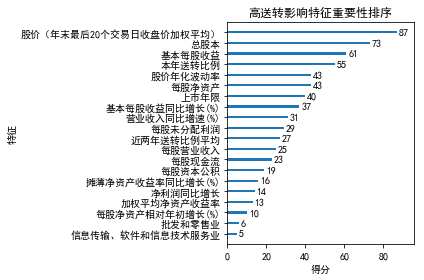

In [70]:
# 特征重要性
from xgboost import plot_importance
import matplotlib.pyplot as plt
# 解决中文和负号显示问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 使显示图标自适应
plt.rcParams['figure.autolayout'] = True
plot_importance(clf, title='高送转影响特征重要性排序', xlabel='得分', ylabel='特征', grid=False, max_num_features = 20)
plt.show()